In [1]:
# testing the objects from ndglobal search

In [2]:
import torch
# setup
dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
sigma_max = 0.12
sigma_min = 0.02
def mme_add_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    y = (torch.exp(-(100.*(x1-0.65))**2.)) * (torch.exp(-(50.*(x2-0.65))**2.))
    y += 0.7*(torch.exp(-(100.*(x1-0.25))**2.)) * (torch.exp(-(50.*(x2-0.35))**2.))
    y += 0.8*(torch.exp(-(100.*(x1-0.8))**2.)) * (torch.exp(-(50.*(x2-0.15))**2.))
    y += 0.66*(-1.*x2*x1 + 0.1*torch.sin(30.*x1*x2)) + 0.73
    return y

def mme_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    # mean
    y = mme_add_2d(X)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

def outcome_objective(x):
    """wrapper for the outcome objective function"""
    return mme_2d(x).type_as(x).unsqueeze(-1)

In [4]:
def generate_initial_data_with_function(obj_func, n=10, eval_limit: int = None, dim: int = 1):
    """generate initial set of data with a given objective function"""
    if eval_limit is not None:
        n = min(n, eval_limit)
    train_x = torch.rand(n, dim, device=device, dtype=dtype)
    exact_obj = obj_func(train_x)
    train_obj = exact_obj
    best_observed_value = exact_obj.max().item()
    return train_x, train_obj, best_observed_value

In [5]:
test_x, test_y, test_best = generate_initial_data_with_function(outcome_objective, dim=2)

In [6]:
test_x[0].shape

torch.Size([2])

In [7]:
test_x

tensor([[0.3210, 0.9407],
        [0.0317, 0.1501],
        [0.2561, 0.1050],
        [0.4898, 0.7927],
        [0.2840, 0.3821],
        [0.8355, 0.9285],
        [0.3850, 0.4339],
        [0.6163, 0.0497],
        [0.8800, 0.2508],
        [0.8134, 0.9842]], dtype=torch.float64)

In [8]:
test_best

0.8260446341757935

In [9]:
test_ob = [(test_x[0].unsqueeze(-1), test_y[0].unsqueeze(-1)),
           (test_x[1].unsqueeze(-1), test_y[1].unsqueeze(-1)),
           (test_x[2].unsqueeze(-1), test_y[2].unsqueeze(-1))]

In [10]:
test_ob[0][0].shape

torch.Size([2, 1])

In [11]:
test_ob

[(tensor([[0.3210],
          [0.9407]], dtype=torch.float64),
  tensor([[0.5742]], dtype=torch.float64)),
 (tensor([[0.0317],
          [0.1501]], dtype=torch.float64),
  tensor([[0.6198]], dtype=torch.float64)),
 (tensor([[0.2561],
          [0.1050]], dtype=torch.float64),
  tensor([[0.5272]], dtype=torch.float64))]

In [12]:
dists = []
for i in range(len(test_ob)):
    for j in range(len(test_ob)):
        dists.append(torch.linalg.norm(test_ob[i][0] - test_ob[j][0]))

In [13]:
dists

[tensor(0., dtype=torch.float64),
 tensor(0.8418, dtype=torch.float64),
 tensor(0.8382, dtype=torch.float64),
 tensor(0.8418, dtype=torch.float64),
 tensor(0., dtype=torch.float64),
 tensor(0.2289, dtype=torch.float64),
 tensor(0.8382, dtype=torch.float64),
 tensor(0.2289, dtype=torch.float64),
 tensor(0., dtype=torch.float64)]

In [14]:
test_ex_y, test_id = torch.max(test_y, dim=0, keepdim=True)

In [15]:
test_ex_y

tensor([[0.8260]], dtype=torch.float64)

In [16]:
test_x[test_id[0]]

tensor([[0.6163, 0.0497]], dtype=torch.float64)

In [17]:
x_ext_test = test_x[4]
x_ext_test

tensor([0.2840, 0.3821], dtype=torch.float64)

In [18]:
test_rad = torch.tensor(0.25)
test_lb = x_ext_test - test_rad
test_lb

tensor([0.0340, 0.1321], dtype=torch.float64)

In [19]:
test_ub = x_ext_test + test_rad
test_ub

tensor([0.5340, 0.6321], dtype=torch.float64)

In [20]:
test_ext_bounds = torch.stack([test_lb, test_ub], dim=0)
test_ext_bounds

tensor([[0.0340, 0.1321],
        [0.5340, 0.6321]], dtype=torch.float64)

In [23]:
test_global_bounds = torch.tensor([[0.0, 0.1],[0.8, 0.2]], dtype=dtype)

In [24]:
test_global_bounds

tensor([[0.0000, 0.1000],
        [0.8000, 0.2000]], dtype=torch.float64)

In [25]:
test_global_bounds[0]

tensor([0.0000, 0.1000], dtype=torch.float64)

In [26]:
test_x

NameError: name 'test_x' is not defined

In [25]:
id_u = torch.where(test_x <= test_global_bounds[1], True, False)
id_u

tensor([[ True, False],
        [ True,  True],
        [ True,  True],
        [ True, False],
        [ True, False],
        [False, False],
        [ True, False],
        [ True,  True],
        [False, False],
        [False, False]])

In [26]:
id_l = torch.where(test_x > test_global_bounds[0], True, False)
id_l

tensor([[ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True, False],
        [ True,  True],
        [ True,  True]])

In [27]:
id_both = id_u & id_l
id_both

tensor([[ True, False],
        [ True,  True],
        [ True,  True],
        [ True, False],
        [ True, False],
        [False, False],
        [ True, False],
        [ True, False],
        [False, False],
        [False, False]])

In [28]:
x_in = test_x[torch.all(id_both, dim=1), :]

In [29]:
x_in

tensor([[0.0317, 0.1501],
        [0.2561, 0.1050]], dtype=torch.float64)

In [30]:
y_in = test_y[torch.all(id_both, dim=1)]
y_in

tensor([[0.6198],
        [0.5272]], dtype=torch.float64)

In [31]:
# testing partitioning bound split
initial_bound = torch.tensor([[0.2, 0.0],[0.4, 1.0]], dtype=dtype)
print("initial lower bounds: ", initial_bound[0])
print("initial upper bounds: ", initial_bound[1])

initial lower bounds:  tensor([0.2000, 0.0000], dtype=torch.float64)
initial upper bounds:  tensor([0.4000, 1.0000], dtype=torch.float64)


In [32]:
# pick a random dim to split
input_dim = 2
split_dim = torch.randint(0, input_dim, (1,))
split_dim

tensor([0])

In [33]:
# calculate the center of the bounds on that split dim, and which then becomes new bound limit
center_bound = (initial_bound[1, split_dim] - initial_bound[0, split_dim])/2.0 + initial_bound[0, split_dim]
center_bound

tensor([0.3000], dtype=torch.float64)

In [34]:
new_left_bound = initial_bound.clone()
new_left_bound[1, split_dim] = center_bound
print("new left bound: ", new_left_bound)

new left bound:  tensor([[0.2000, 0.0000],
        [0.3000, 1.0000]], dtype=torch.float64)


In [35]:
new_right_bound = initial_bound.clone()
new_right_bound[0, split_dim] = center_bound
print('new right bound: ', new_right_bound)

new right bound:  tensor([[0.3000, 0.0000],
        [0.4000, 1.0000]], dtype=torch.float64)


In [36]:
initial_bound

tensor([[0.2000, 0.0000],
        [0.4000, 1.0000]], dtype=torch.float64)

In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from botorch import fit_gpytorch_mll

from extremasearch.local.ndlocalsearch import NdLocalSearchState, NdLocalExtremeSearch

# setup
dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\alexb\PycharmProjects\extrema_search\venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


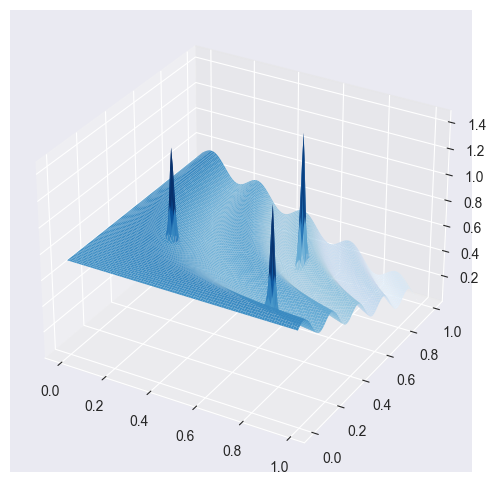

In [2]:
import matplotlib.pyplot as plt
# and with addition of smooth global behavior
def mme_add_2d_plot(x1, x2):
    y = (torch.exp(-(100.*(x1-0.65))**2.)) * (torch.exp(-(50.*(x2-0.65))**2.))
    y += 0.7*(torch.exp(-(100.*(x1-0.25))**2.)) * (torch.exp(-(50.*(x2-0.35))**2.))
    y += 0.8*(torch.exp(-(100.*(x1-0.8))**2.)) * (torch.exp(-(50.*(x2-0.15))**2.))
    y += 0.66*(-1.*x2*x1 + 0.1*torch.sin(30.*x1*x2)) + 0.73
    return y

x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = mme_add_2d_plot(X1, X2)
from matplotlib import ticker, cm
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8,6))

from matplotlib.colors import LightSource
ls = LightSource(270, 45)
rgb = ls.shade(Z.numpy(), cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0)

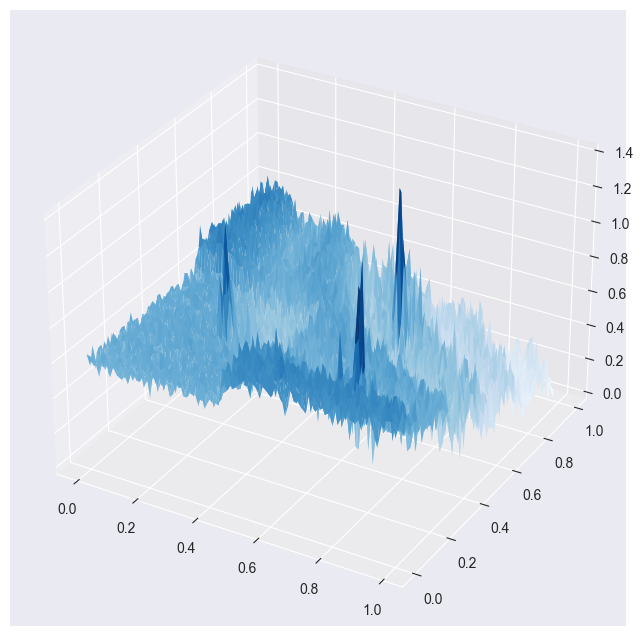

In [3]:
sigma_max = 0.12
sigma_min = 0.02
def noise_1_2d(x1, x2):
    # mean
    y = mme_add_2d_plot(x1, x2)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0)

In [4]:
sigma_max = 0.12
sigma_min = 0.02
def mme_add_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    y = (torch.exp(-(100.*(x1-0.65))**2.)) * (torch.exp(-(50.*(x2-0.65))**2.))
    y += 0.7*(torch.exp(-(100.*(x1-0.25))**2.)) * (torch.exp(-(50.*(x2-0.35))**2.))
    y += 0.8*(torch.exp(-(100.*(x1-0.8))**2.)) * (torch.exp(-(50.*(x2-0.15))**2.))
    y += 0.66*(-1.*x2*x1 + 0.1*torch.sin(30.*x1*x2)) + 0.73
    return y

def mme_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    # mean
    y = mme_add_2d(X)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

def outcome_objective(x):
    """wrapper for the outcome objective function"""
    return mme_2d(x).type_as(x).unsqueeze(-1)

In [5]:
from extremasearch.globalmm.ndglobalsearch import MultimodalExtremaSearch

In [6]:
test_nd_global_search = MultimodalExtremaSearch(obj_func=outcome_objective, input_dim=2,
                                                tead_model_type='piecewise')

In [7]:
test_nd_global_search.run_global_search()

Setting up global state
tead
tead
tead
tead
tead
tead
tead
tead
tead
tead
tead
Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  0  tead score:  tensor(1.2980, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: Selecting node  0  for split with score  1.2979777880029892
Running partition
PARTITION: Splitting node  0  from  tensor([[0., 0.],
        [1., 1.]], dtype=torch.float64)  to  tensor([[0.0000, 0.0000],
        [0.5000, 1.0000]], dtype=torch.float64)  and  tensor([[0.5000, 0.0000],
        [1.0000, 1.0000]], dtype=torch.float64)
PARTITION: New node  1  new edge from  0  to  1
PARTITION: New node  2  new edge from  0  to  2
Running subdomain selection
SELECT: For node  1  best x:  tensor([[0.3119, 0.3589]],

In [8]:
g = test_nd_global_search.global_state.partition_graph

In [45]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
graph_leaves = [n for n in g if g.out_degree[n] == 0]
for n in graph_leaves:
    current_node = g.nodes()[n]
    current_state = current_node['data']
    current_state.local_model = SingleTaskGP(current_state.x_local, current_state.y_local,
                                             input_transform=Normalize(d=current_state.x_local.shape[-1]),
                                             outcome_transform=Standardize(m=current_state.y_local.shape[-1]))
    current_state.local_mll = ExactMarginalLogLikelihood(current_state.local_model.likelihood,
                                                         current_state.local_model)
    fit_gpytorch_mll(current_state.local_mll)

IndexError: amin(): Expected reduction dim 0 to have non-zero size.

In [48]:
current_state.x_local

tensor([], size=(0, 2), dtype=torch.float64)

In [50]:
current_state.local_bounds

tensor([[0.1250, 0.0000],
        [0.2500, 0.5000]], dtype=torch.float64)

In [9]:
# functions for getting and working with data from searches
def get_bounds(graph):
    """Get the bounds for each node in a graph to be able to plot them"""
    graph_leaves = [n for n in graph if graph.out_degree[n] == 0]
    bound_list = []
    node_list = []
    for n in graph_leaves:
        # get current leaf node
        current_node = graph.nodes()[n]
        current_state = current_node['data']
        current_bounds = current_state.local_bounds
        node_list.append(n)
        bound_list.append(current_bounds)
        print(current_state.x_local.shape)
    return node_list, bound_list

In [10]:
leaf_nodes, leaf_bounds = get_bounds(g)

torch.Size([9, 2])
torch.Size([17, 2])
torch.Size([56, 2])
torch.Size([7, 2])
torch.Size([12, 2])


In [59]:
leaf_bounds[0]

tensor([[0.5000, 0.0000],
        [1.0000, 1.0000]], dtype=torch.float64)

(0.0, 1.0)

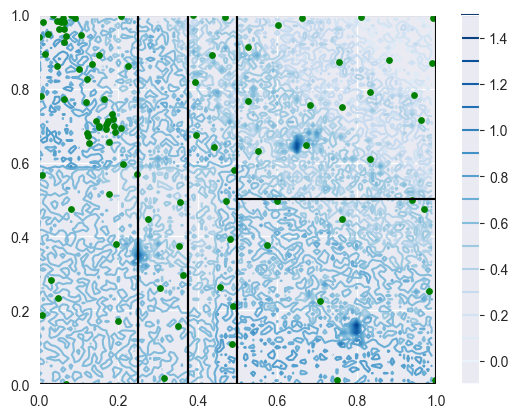

In [11]:
x_plot = test_nd_global_search.global_state.x_global


fig1, ax1 = plt.subplots()
CS = ax1.contour(X1, X2, Z, levels=15, cmap='Blues')
cbar = fig1.colorbar(CS)
ax1.scatter(x_plot[:,0].numpy(), x_plot[:,1].numpy(), s=15, marker='o', color='g', zorder=2)
for i in range(len(leaf_bounds)):
    ax1.plot([leaf_bounds[i][0,0], leaf_bounds[i][1,0]], [leaf_bounds[i][0,1], leaf_bounds[i][0,1]], color='k')
    ax1.plot([leaf_bounds[i][1,0], leaf_bounds[i][1,0]], [leaf_bounds[i][0,1], leaf_bounds[i][1,1]], color='k')
    ax1.plot([leaf_bounds[i][1,0], leaf_bounds[i][0,0]], [leaf_bounds[i][1,1], leaf_bounds[i][1,1]], color='k')
    ax1.plot([leaf_bounds[i][0,0], leaf_bounds[i][0,0]], [leaf_bounds[i][1,1], leaf_bounds[i][0,1]], color='k')
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])

In [12]:
test_bounds = leaf_bounds[4]

In [13]:
idx_ub = torch.where(x_plot < test_bounds[1], True, False)
idx_lb = torch.where(x_plot >= test_bounds[0], True, False)
idx_both = idx_lb & idx_ub
idx_select = torch.all(idx_both, dim=1)
local_x = x_plot[idx_select]

In [14]:
local_x

tensor([[3.8151e-01, 9.9776e-01],
        [3.4658e-04, 9.2421e-01],
        [4.7075e-01, 8.8064e-01],
        [4.6418e-01, 9.2785e-01],
        [2.4551e-02, 9.9751e-01],
        [2.2764e-03, 9.7129e-01],
        [4.7057e-02, 9.1371e-01],
        [3.6820e-02, 8.7712e-01],
        [2.5760e-02, 8.8084e-01],
        [2.1657e-02, 9.5228e-01],
        [2.5625e-03, 9.4895e-01],
        [7.0594e-03, 9.0632e-01],
        [1.5175e-05, 9.3383e-01],
        [2.1897e-01, 8.9564e-01],
        [2.2277e-01, 9.2326e-01],
        [2.1420e-01, 9.1319e-01],
        [2.1665e-01, 9.1077e-01],
        [2.2298e-01, 8.8728e-01],
        [2.3232e-01, 8.8868e-01],
        [4.2221e-04, 9.9863e-01],
        [1.1144e-01, 9.2254e-01],
        [2.7325e-04, 9.0016e-01],
        [4.5279e-02, 9.3278e-01],
        [3.1789e-04, 9.1901e-01],
        [5.8051e-04, 9.1301e-01],
        [6.8313e-05, 9.5215e-01],
        [1.4703e-02, 9.1077e-01],
        [2.0848e-02, 9.2242e-01],
        [1.8486e-02, 9.4693e-01],
        [2.390

In [20]:
x_ex = torch.tensor([[0.1, 1.0]])
idx = torch.where(x_ex >= 1.0, True, False)
x_ex[idx] = 0.999999
idx = torch.where(x_ex >= 1.0, True, False)
idx

tensor([[False, False]])

In [22]:
x_ex.dtype

torch.float32

In [27]:
test_global_bounds

tensor([[0.0000, 0.1000],
        [0.8000, 0.2000]], dtype=torch.float64)

In [40]:
x1 = torch.tensor([0.79, 0.15], dtype=dtype)

In [41]:
idx_ub = torch.where(x1 < test_global_bounds[1], True, False)
idx_lb = torch.where(x1 >= test_global_bounds[0], True, False)
idx_both = idx_lb & idx_ub

In [42]:
idx_ub

tensor([True, True])

In [43]:
idx_lb

tensor([True, True])

In [44]:
idx_both

tensor([True, True])

In [45]:
torch.all(idx_both)

tensor(True)

In [46]:
if torch.all(idx_both):
    print('go')

go
